### Install dependencies and import

In [ ]:
!pip -q install pandas numpy scikit-learn tqdm

In [ ]:
import os, json, re, hashlib

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import display

### Load CUAD

In [ ]:
with open(f"/content/drive/MyDrive/CUAD_v1.json", "r", encoding="utf-8") as f:
    raw = json.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Flatten Cuad

In [ ]:
def flatten_cuad(records):
    rows = []
    for doc in records:
        title = doc.get("title") or doc.get("document_title") or "unknown"
        for para in doc.get("paragraphs", []):
            context = para.get("context", "")
            for qa in para.get("qas", []):
                rows.append({
                    "title": title,
                    "context": context,
                    "question": qa.get("question", ""),
                    "answers": qa.get("answers", {"text": [], "answer_start": []}),
                    "is_impossible": qa.get("is_impossible", False),
                    "id": qa.get("id")
                })
    return rows

In [ ]:
df_qa = pd.DataFrame(flatten_cuad(raw["data"]))
df_ctx = df_qa[["title","context"]].drop_duplicates().reset_index(drop=True)
print("QA rows:", len(df_qa))
print("Unique (title, context) passages:", len(df_ctx))

df_qa.head(2)

QA rows: 20910
Unique (title, context) passages: 510


,title,context,question,answers,is_impossible,id
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,EXHIBIT 10.6\n\n ...,Highlight the parts (if any) of this contract ...,"[{'text': 'DISTRIBUTOR AGREEMENT', 'answer_sta...",False,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...
1,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,EXHIBIT 10.6\n\n ...,Highlight the parts (if any) of this contract ...,"[{'text': 'Distributor', 'answer_start': 244},...",False,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...


### Normalize

In [ ]:
def _norm(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return text.replace("\r\n","\n").replace("\r","\n")

In [ ]:
print("answers types:", df_qa["answers"].map(type).value_counts().to_dict())
print("example answers (first 3):")
for i in range(3):
    print(df_qa.loc[i,"answers"])

answers types: {<class 'list'>: 20910}
example answers (first 3):
[{'text': 'DISTRIBUTOR AGREEMENT', 'answer_start': 44}]
[{'text': 'Distributor', 'answer_start': 244}, {'text': 'Electric City Corp.', 'answer_start': 148}, {'text': 'Electric City of Illinois L.L.C.', 'answer_start': 49574}, {'text': 'Company', 'answer_start': 197}, {'text': 'Electric City of Illinois LLC', 'answer_start': 212}]
[{'text': '7th day of September, 1999.', 'answer_start': 263}]


### Extract answers

In [ ]:
def extract_first_text(ans):
    if isinstance(ans, dict):
        t = ans.get("text", [])
        if isinstance(t, list):
            for z in t:
                if isinstance(z, str) and z.strip():
                    return z.strip()
        elif isinstance(t, str) and t.strip():
            return t.strip()
    elif isinstance(ans, list):
        for a in ans:
            if isinstance(a, dict):
                z = a.get("text", "")
                if isinstance(z, str) and z.strip():
                    return z.strip()
    return ""

def extract_first_start(ans):
    if isinstance(ans, dict):
        s = ans.get("answer_start", [])
        if isinstance(s, list) and s:
            try:
                v = int(s[0])
                return v if v >= 0 else None
            except Exception:
                return None
        try:
            v = int(s)
            return v if v >= 0 else None
        except Exception:
            return None
    elif isinstance(ans, list):
        for a in ans:
            if isinstance(a, dict) and "answer_start" in a:
                try:
                    v = int(a["answer_start"])
                    return v if v >= 0 else None
                except Exception:
                    continue
    return None

def compute_astart_with_fallback(context, ans):
    s = extract_first_start(ans)
    if s is not None:
        return s
    ctx = _norm(context)
    t = extract_first_text(ans)
    if t:
        i = _norm(ctx).find(t)
        return i if i >= 0 else None
    return None

### Attach context hash and derive label from question

In [ ]:
df_ctx2 = df_ctx.copy()
df_ctx2["context_hash"] = df_ctx2["context"].map(lambda s: hashlib.md5(_norm(s).encode("utf-8")).hexdigest()[:12])
df_qa2 = df_qa.merge(df_ctx2[["title","context","context_hash"]], on=["title","context"], how="left")

_QUOTED = re.compile(r'"([^"]+)"')
def question_to_label(q: str) -> str:
    if not isinstance(q, str):
        return ""
    m = _QUOTED.search(q)
    return m.group(1).strip() if m else q.strip()

df_qa2["label"] = df_qa2["question"].map(question_to_label)
df_qa2["astart"] = df_qa2.apply(lambda r: compute_astart_with_fallback(r["context"], r["answers"]), axis=1)

df_qa2["is_impossible"] = df_qa2["is_impossible"].astype(bool)

df_qa_pos = df_qa2[(df_qa2["astart"].notna()) & (~df_qa2["is_impossible"])].copy()
df_qa_pos["astart"] = df_qa_pos["astart"].astype(int)
print("Usable QA rows:", len(df_qa_pos), "of", len(df_qa2))

Usable QA rows: 6702 of 20910


### Create df clauses

In [ ]:
df_qa_pos["answer_text"] = df_qa_pos["answers"].map(extract_first_text)
df_qa_pos["aend"] = df_qa_pos["astart"] + df_qa_pos["answer_text"].str.len()

clauses_data = []
for idx, row in df_qa_pos.iterrows():
    clauses_data.append({
        "contract_id": row["title"],
        "context_hash": row["context_hash"],
        "clause_idx": idx,
        "start": row["astart"],
        "end": row["aend"],
        "text": row["answer_text"],
        "label": row["label"],
        "context": row["context"]
    })

df_clauses = pd.DataFrame(clauses_data)
print(f"Created df_clauses with {len(df_clauses)} rows")
print("Sample df_clauses:")
print(df_clauses.head())

Created df_clauses with 6702 rows
Sample df_clauses:
                                         contract_id  context_hash  \
0  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
1  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
2  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
3  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
4  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   

   clause_idx  start   end                                               text  \
0           0     44    65                              DISTRIBUTOR AGREEMENT   
1           1    244   255                                        Distributor   
2           2    263   290                        7th day of September, 1999.   
3           3   5268  5541  The term of this  Agreement  shall be ten (10)...   
4           4   5268  5541  The term of this  Agreement  shall be ten (10)...   

             label                     

In [ ]:
df_qa_pos["answer_text"] = df_qa_pos["answers"].map(extract_first_text)
df_qa_pos["aend"] = df_qa_pos["astart"] + df_qa_pos["answer_text"].str.len()

clauses_data = []
for idx, row in df_qa_pos.iterrows():
    clauses_data.append({
        "contract_id": row["title"],
        "context_hash": row["context_hash"],
        "clause_idx": idx,
        "start": row["astart"],
        "end": row["aend"],
        "text": row["answer_text"],
        "label": row["label"],
        "context": row["context"]
    })

df_clauses = pd.DataFrame(clauses_data)
print(f"Created df_clauses with {len(df_clauses)} rows")
print("Sample df_clauses:")
print(df_clauses.head())

Created df_clauses with 6702 rows
Sample df_clauses:
                                         contract_id  context_hash  \
0  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
1  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
2  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
3  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   
4  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...  41f7921a654e   

   clause_idx  start   end                                               text  \
0           0     44    65                              DISTRIBUTOR AGREEMENT   
1           1    244   255                                        Distributor   
2           2    263   290                        7th day of September, 1999.   
3           3   5268  5541  The term of this  Agreement  shall be ten (10)...   
4           4   5268  5541  The term of this  Agreement  shall be ten (10)...   

             label                     

In [ ]:
print(f"\nUnique clause types found: {df_clauses['label'].nunique()}")
print("Label distribution:")
print(df_clauses['label'].value_counts().head(10))


Unique clause types found: 41
Label distribution:
label
Document Name       510
Parties             509
Agreement Date      470
Governing Law       437
Expiration Date     413
Effective Date      390
Anti-Assignment     374
Cap On Liability    275
License Grant       255
Audit Rights        214
Name: count, dtype: int64


### Multi Label Encoding

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict


all_labels = df_clauses['label'].unique()
print(f"Found {len(all_labels)} unique clause types:")
print(list(all_labels)[:10], "..." if len(all_labels) > 10 else "")

label_names = sorted(all_labels)
print(f"\nTotal label_names: {len(label_names)}")

print("\nGrouping clauses by document context : ")
grouped_clauses = []

for (contract_id, context_hash), group in df_clauses.groupby(['contract_id', 'context_hash']):
    context = group.iloc[0]['context']

    labels_in_context = group['label'].unique().tolist()

    grouped_clauses.append({
        'contract_id': contract_id,
        'context_hash': context_hash,
        'clause_text': context,
        'labels': labels_in_context
    })

df_grouped = pd.DataFrame(grouped_clauses)
print(f"Created {len(df_grouped)} context-level samples")

print("\n Multi-label binary vectors : ")
mlb = MultiLabelBinarizer()
mlb.fit([label_names])

y_multi_list = []
for labels in df_grouped['labels']:
    binary_vec = mlb.transform([labels])[0]
    y_multi_list.append(binary_vec)

df_grouped['y_multi'] = y_multi_list

df_labeled = df_grouped.copy()

print(f"Multi-label encoding complete!")
print(f"Shape of each y_multi vector: {len(y_multi_list[0])}")
print(f"df_labeled shape: {df_labeled.shape}")

sample_labels = df_labeled.iloc[0]['labels']
sample_y_multi = df_labeled.iloc[0]['y_multi']
print(f"\nSample verification:")
print(f"Original labels: {sample_labels}")
print(f"Encoded vector sum: {sample_y_multi.sum()}")
print(f"Non-zero positions: {np.where(sample_y_multi == 1)[0]}")


print("\nSample of df_labeled:")
print(df_labeled[['contract_id', 'labels']].head())

labels_per_sample = [len(labels) for labels in df_labeled['labels']]
print(f"\nLabels per sample statistics:")
print(f"Mean: {np.mean(labels_per_sample):.2f}")
print(f"Min: {np.min(labels_per_sample)}")
print(f"Max: {np.max(labels_per_sample)}")

Found 41 unique clause types:
['Document Name', 'Parties', 'Agreement Date', 'Effective Date', 'Expiration Date', 'Renewal Term', 'Governing Law', 'Exclusivity', 'No-Solicit Of Customers', 'No-Solicit Of Employees'] ...

Total label_names: 41

Grouping clauses by document context : 
Created 510 context-level samples

 Multi-label binary vectors : 
Multi-label encoding complete!
Shape of each y_multi vector: 41
df_labeled shape: (510, 5)

Sample verification:
Original labels: ['Document Name', 'Parties', 'Agreement Date', 'Effective Date', 'Expiration Date', 'Renewal Term', 'Notice Period To Terminate Renewal', 'Governing Law', 'Non-Compete', 'Change Of Control', 'Anti-Assignment', 'Revenue/Profit Sharing', 'Joint Ip Ownership', 'License Grant', 'Non-Transferable License', 'Post-Termination Services', 'Audit Rights', 'Uncapped Liability', 'Cap On Liability']
Encoded vector sum: 19
Non-zero positions: [ 2  3  4  5  6  9 10 12 13 17 18 24 26 27 28 29 31 32 37]

Sample of df_labeled:
     

### Analyze class imbalance

In [ ]:
import numpy as np, pandas as pd

assert "y_multi" in df_labeled.columns, "Run the labeling step first."
assert 'label_names' in globals(), "Make sure label_names is defined."

Y = np.stack(df_labeled["y_multi"].to_list()).astype(np.int64)
N = len(df_labeled)
counts = Y.sum(axis=0)
preval  = counts / max(N, 1)

freq = (pd.DataFrame({"label": label_names, "count": counts, "prevalence": preval})
          .sort_values("prevalence", ascending=False)
          .reset_index(drop=True))

avg_labels_per_clause = Y.sum()/max(N,1)
pct_empty = (Y.sum(axis=1)==0).mean()*100
num_rare   = int((freq["prevalence"] < 0.02).sum())
num_common = int((freq["prevalence"] > 0.20).sum())

if (counts > 0).any():
    min_pos_prev = float(preval[counts>0].min())
    imbalance_ratio = float(preval.max() / max(min_pos_prev, 1/N))
else:
    min_pos_prev = 0.0
    imbalance_ratio = float("inf")

is_imbalanced = (num_rare > 0) or (num_common > 0) or (imbalance_ratio > 10)

print({
    "samples": int(N),
    "labels": len(label_names),
    "avg_labels_per_clause": round(float(avg_labels_per_clause), 3),
    "clauses_with_no_labels_%": round(float(pct_empty), 2),
    "rare_labels_<2%": num_rare,
    "common_labels_>20%": num_common,
    "max_prevalence": round(float(preval.max()), 4),
    "min_positive_prevalence": round(float(min_pos_prev), 4),
    "imbalance_ratio_max/minpos": None if np.isinf(imbalance_ratio) else round(float(imbalance_ratio), 2),
    "IMBALANCED": bool(is_imbalanced),
})

display(freq.head(5))
display(freq.tail(5))

{'samples': 510, 'labels': 41, 'avg_labels_per_clause': 13.141, 'clauses_with_no_labels_%': 0.0, 'rare_labels_<2%': 0, 'common_labels_>20%': 23, 'max_prevalence': 1.0, 'min_positive_prevalence': 0.0255, 'imbalance_ratio_max/minpos': 39.23, 'IMBALANCED': True}


,label,count,prevalence
0,Document Name,510,1.000000
1,Parties,509,0.998039
2,Agreement Date,470,0.921569
3,Governing Law,437,0.856863
4,Expiration Date,413,0.809804


,label,count,prevalence
36,Most Favored Nation,28,0.054902
37,Affiliate License-Licensor,23,0.045098
38,Unlimited/All-You-Can-Eat-License,17,0.033333
39,Price Restrictions,15,0.029412
40,Source Code Escrow,13,0.025490


### Split into train , test and val

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd

titles = df_labeled["contract_id"].unique()
train_t, test_t = train_test_split(titles, test_size=0.20, random_state=42)
train_t, val_t  = train_test_split(train_t, test_size=0.20, random_state=42)

def take(ids):
    return df_labeled[df_labeled["contract_id"].isin(ids)].reset_index(drop=True)

train_df = take(train_t)
val_df   = take(val_t)
test_df  = take(test_t)

def quick_stats(df):
    Y = np.stack(df["y_multi"].to_list())
    return {"n": len(df), "pct_labeled": round(100*(Y.sum(axis=1)>0).mean(), 2)}

print("stats:",
      {"train": quick_stats(train_df),
       "val":   quick_stats(val_df),
       "test":  quick_stats(test_df)})

stats: {'train': {'n': 326, 'pct_labeled': np.float64(100.0)}, 'val': {'n': 82, 'pct_labeled': np.float64(100.0)}, 'test': {'n': 102, 'pct_labeled': np.float64(100.0)}}


### Label and row weights to address class imbalance

In [ ]:
Y_tr = np.stack(train_df["y_multi"].to_list())
N_tr = len(train_df)
counts_tr = Y_tr.sum(axis=0)
pos_weight = (N_tr - counts_tr) / np.clip(counts_tr, 1, None)
print("pos_weight shape:", pos_weight.shape)

pos_weight shape: (41,)


In [ ]:
def row_weight(y):
    y = np.asarray(y, dtype=int)
    return 1.0 if y.sum()==0 else float(pos_weight[y==1].mean())

train_df["sample_weight"] = train_df["y_multi"].apply(row_weight)
val_df["sample_weight"]   = val_df["y_multi"].apply(row_weight)
test_df["sample_weight"]  = test_df["y_multi"].apply(row_weight)

train_bal = train_df
print("row-weighted training size:", len(train_bal))

row-weighted training size: 326


In [ ]:
import numpy as np, pandas as pd

Y_tr = np.stack(train_df["y_multi"].to_list())
N_tr = len(train_df)
counts_tr = Y_tr.sum(axis=0)
prev_tr   = counts_tr / max(N_tr, 1)

pos_weight = (N_tr - counts_tr) / np.clip(counts_tr, 1, None)

proof = (pd.DataFrame({
    "label": label_names,
    "train_count": counts_tr,
    "train_prevalence": prev_tr,
    "pos_weight": pos_weight
})
.sort_values("pos_weight", ascending=False))

print("We used per-label BCE pos_weight ( (N - P) / P ) to counter rare labels.")
print("Top 10 most-upweighted labels:")
display(proof.head(10))

print("Summary:",
      {"min_weight": float(pos_weight[counts_tr>0].min()) if (counts_tr>0).any() else None,
       "max_weight": float(pos_weight.max()),
       "median_weight": float(np.median(pos_weight))})


We used per-label BCE pos_weight ( (N - P) / P ) to counter rare labels.
Top 10 most-upweighted labels:


,label,train_count,train_prevalence,pos_weight
34,Source Code Escrow,5,0.015337,64.200000
30,Price Restrictions,10,0.030675,31.600000
38,Unlimited/All-You-Can-Eat-License,10,0.030675,31.600000
21,Most Favored Nation,15,0.046012,20.733333
1,Affiliate License-Licensor,15,0.046012,20.733333
36,Third Party Beneficiary,22,0.067485,13.818182
25,Non-Disparagement,23,0.070552,13.173913
22,No-Solicit Of Customers,24,0.073620,12.583333
17,Joint Ip Ownership,31,0.095092,9.516129
23,No-Solicit Of Employees,35,0.107362,8.314286


Summary: {'min_weight': 0.0, 'max_weight': 64.2, 'median_weight': 3.4657534246575343}


### Preprocessing

In [ ]:
import re, unicodedata

def clean_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = unicodedata.normalize("NFKC", s)
    s = s.replace("\r\n","\n").replace("\r","\n")
    s = re.sub(r"[\t]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    return s.strip()

df_labeled["clause_text_raw"] = df_labeled["clause_text"]
df_labeled["clause_text"] = df_labeled["clause_text"].apply(clean_text)

print("Cleaned texts. Example:\n---\n", df_labeled.loc[0,"clause_text"][:400])
print("\nNum labels discovered:", len(label_names))

Cleaned texts. Example:
---
 CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-BRANDING AND ADVERTISING AGREEMENT (the "Agreement") is made as of June 21, 1999 (the "Effective Date") by and between I-ESCROW, INC., with its principal place of business at 1730 S. Amphlett Blvd., Suite 233, San Mateo, California 94402 ("i-Escrow"), and 2THEMART.COM, INC. having its principal place of business at 18301 Von Karman Avenue, 7th Floor, I

Num labels discovered: 41


### Tf - Idf features

In [ ]:
import time, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier, LogisticRegression


vec = TfidfVectorizer(max_features=100_000, ngram_range=(1,2), min_df=2,
                      sublinear_tf=True, strip_accents="unicode")
Xtr = vec.fit_transform(train_bal["clause_text"])
Xv  = vec.transform(val_df["clause_text"])
Xte = vec.transform(test_df["clause_text"])


Xtr_text = train_bal["clause_text"].tolist()
Ytr = np.stack(train_bal["y_multi"].to_list()).astype(int)
Wtr = train_bal.get("sample_weight", pd.Series(1.0, index=train_bal.index)).to_numpy()

Xv_text = val_df["clause_text"].tolist()
Yv = np.stack(val_df["y_multi"].to_list()).astype(int)

Xte_text = test_df["clause_text"].tolist()
Yte = np.stack(test_df["y_multi"].to_list()).astype(int)

print(f"Training samples: {len(Xtr_text)}")
print(f"Validation samples: {len(Xv_text)}")
print(f"Test samples: {len(Xte_text)}")
print(f"Number of labels: {Ytr.shape[1]}")


t0 = time.time()
vec = TfidfVectorizer(
    max_features=15_000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    strip_accents='unicode'
)
Xtr = vec.fit_transform(Xtr_text)
Xv = vec.transform(Xv_text)
Xte = vec.transform(Xte_text)
print(f"TF-IDF built in {time.time()-t0:.1f}s | shape={Xtr.shape}")

Training samples: 326
Validation samples: 82
Test samples: 102
Number of labels: 41
TF-IDF built in 14.0s | shape=(326, 15000)


### Metrics and Threshold Tuner

In [ ]:
def metrics(y_true, y_pred):
    return {
        "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "micro_precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "micro_recall": recall_score(y_true, y_pred, average="micro", zero_division=0),
        "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

def tune_threshold(y_true, y_prob, metric_key="micro_f1"):
    best_t, best_stats = 0.5, None
    for t in np.linspace(0.1, 0.9, 17):
        s = metrics(y_true, (y_prob >= t).astype(int))
        if best_stats is None or s[metric_key] > best_stats[metric_key]:
            best_t, best_stats = float(t), s
    return best_t, best_stats

### Identify labels that can be trained

In [ ]:
label_stats = []
valid_labels = []

for j in range(Ytr.shape[1]):
    y_col = Ytr[:, j]
    n_pos = y_col.sum()
    n_neg = len(y_col) - n_pos

    label_stats.append({
        'label_idx': j,
        'label_name': label_names[j] if j < len(label_names) else f'label_{j}',
        'n_positive': n_pos,
        'n_negative': n_neg,
        'prevalence': n_pos / len(y_col),
        'trainable': n_pos > 0 and n_neg > 0
    })

    if n_pos > 0 and n_neg > 0:
        valid_labels.append(j)

label_df = pd.DataFrame(label_stats)
print(f"Trainable labels: {len(valid_labels)}/{len(label_stats)}")
print(f"Labels with only negatives: {(label_df['n_positive'] == 0).sum()}")
print(f"Labels with only positives: {(label_df['n_negative'] == 0).sum()}")


problematic = label_df[~label_df['trainable']]
if len(problematic) > 0:
    print("\nProblematic labels will be skipped:")
    print(problematic[['label_name', 'n_positive', 'n_negative']].head(10))

Trainable labels: 40/41
Labels with only negatives: 0
Labels with only positives: 1

Problematic labels will be skipped:
      label_name  n_positive  n_negative
9  Document Name         326           0


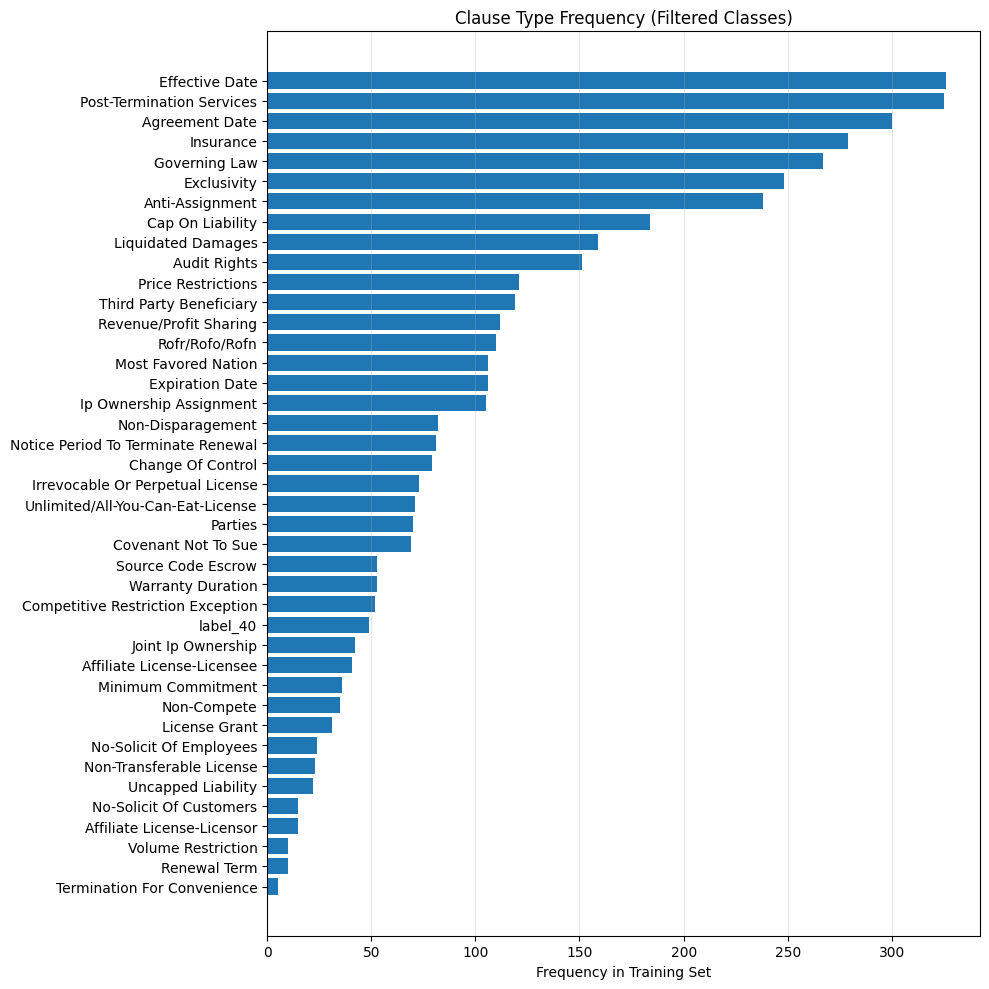

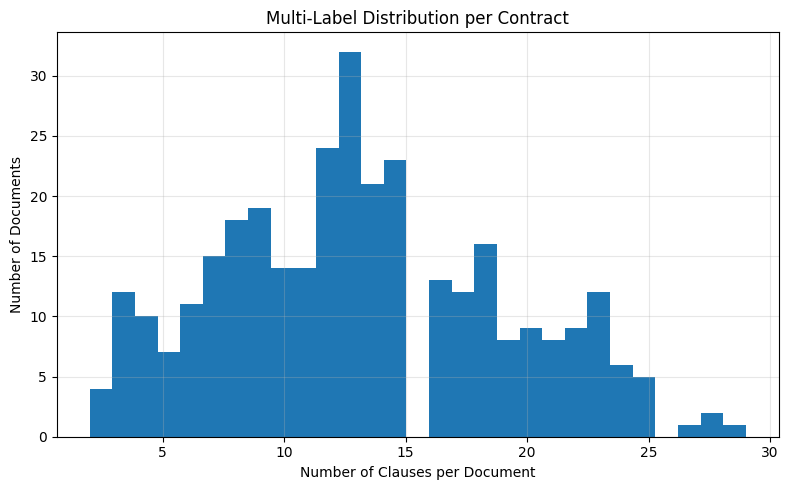

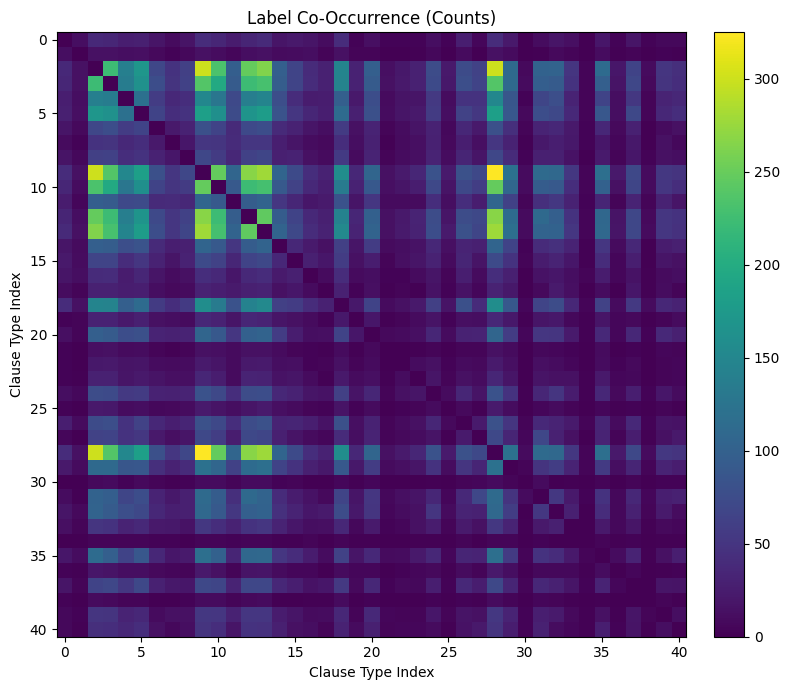

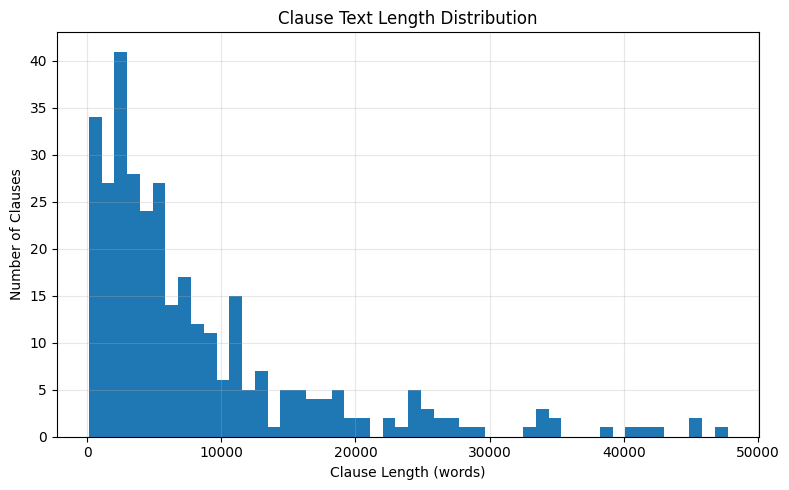

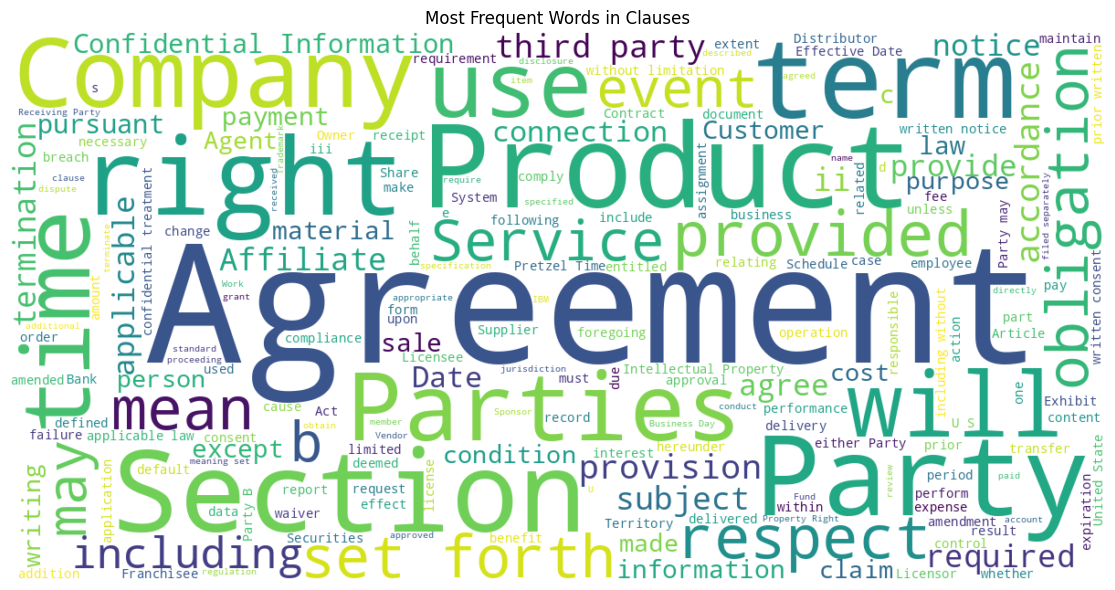

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_train_filtered = np.stack(train_df["y_multi"].to_list()).astype(int)
valid_classes = list(range(y_train_filtered.shape[1]))
valid_classes = list(range(y_train_filtered.shape[1]))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def eda_cuad_overview(train_df, y_train_filtered, class_names=None, top_k=20):


    assert 'clause_text' in train_df.columns, "train_df must contain a 'clause_text' column"

    Y = np.asarray(y_train_filtered)
    assert Y.ndim == 2, "y_train_filtered must be 2D: (num_samples, num_classes)"
    C = Y.shape[1]

    if class_names is None:
        class_names = [f"label_{i}" for i in range(C)]
    else:
        class_names = list(class_names)
        if len(class_names) < C:
            class_names = class_names + [f"label_{i}" for i in range(len(class_names), C)]
        elif len(class_names) > C:
            class_names = class_names[:C]

    freq = Y.sum(axis=0)
    df_freq = (pd.DataFrame({'clause_type': class_names, 'frequency': freq})
                 .sort_values('frequency', ascending=True))
    plt.figure(figsize=(10, max(6, int(C*0.25))))
    y_idx = np.arange(len(df_freq))
    plt.barh(y_idx, df_freq['frequency'].values)
    plt.yticks(y_idx, [n if len(n) <= 50 else n[:47] + '...' for n in df_freq['clause_type']])
    plt.xlabel('Frequency in Training Set')
    plt.title('Clause Type Frequency (Filtered Classes)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    labels_per_doc = Y.sum(axis=1)
    plt.figure(figsize=(8,5))
    plt.hist(labels_per_doc, bins=min(30, max(10, int(labels_per_doc.max()))))
    plt.xlabel('Number of Clauses per Document')
    plt.ylabel('Number of Documents')
    plt.title('Multi-Label Distribution per Contract')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    co = Y.T @ Y
    np.fill_diagonal(co, 0)
    plt.figure(figsize=(8,7))
    im = plt.imshow(co, interpolation='nearest', aspect='auto')
    plt.title('Label Co-Occurrence (Counts)')
    plt.xlabel('Clause Type Index')
    plt.ylabel('Clause Type Index')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    lengths = train_df['clause_text'].astype(str).map(lambda s: len(s.split())).values
    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=50)
    plt.xlabel('Clause Length (words)')
    plt.ylabel('Number of Clauses')
    plt.title('Clause Text Length Distribution')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    try:
        from wordcloud import WordCloud
        text_all = " ".join(train_df['clause_text'].astype(str).tolist())
        wc = WordCloud(width=1200, height=600, background_color='white').generate(text_all)
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title('Most Frequent Words in Clauses')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Skipping word cloud (package missing or error):", e)


eda_cuad_overview(train_df, y_train_filtered, label_names, valid_classes)

### Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import numpy as np

X_train_text = train_df["clause_text"].tolist()
y_train = np.array(train_df["y_multi"].tolist())

X_val_text   = val_df["clause_text"].tolist()
y_val   = np.array(val_df["y_multi"].tolist())

X_test_text  = test_df["clause_text"].tolist()
y_test  = np.array(test_df["y_multi"].tolist())

vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=10_000,
    sublinear_tf=True,
    strip_accents="unicode"
)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_val_vec   = vectorizer.transform(X_val_text)
X_test_vec  = vectorizer.transform(X_test_text)

keep_cols = [j for j in range(y_train.shape[1]) if y_train[:, j].min() != y_train[:, j].max()]
if len(keep_cols) < y_train.shape[1]:
    y_train = y_train[:, keep_cols]
    y_val   = y_val[:,   keep_cols]
    y_test  = y_test[:,  keep_cols]
    try:
        label_names = [label_names[j] for j in keep_cols]
    except Exception:
        pass

logreg = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))
logreg.fit(X_train_vec, y_train)

y_pred_val = logreg.predict(X_val_vec)
y_pred_test = logreg.predict(X_test_vec)

val_stats  = metrics(y_val,  y_pred_val)
test_stats = metrics(y_test, y_pred_test)

print("Logistic Regression F1 Score (Micro):", f1_score(y_test, y_pred_test, average="micro"))
print("VAL :", {k: round(v, 4) for k, v in val_stats.items()})
print("TEST:", {k: round(v, 4) for k, v in test_stats.items()})

Logistic Regression F1 Score (Micro): 0.6724975704567542
VAL : {'micro_f1': 0.699, 'macro_f1': 0.287, 'micro_precision': 0.8626, 'micro_recall': 0.5875, 'macro_precision': 0.4324, 'macro_recall': 0.2716}
TEST: {'micro_f1': 0.6725, 'macro_f1': 0.2703, 'micro_precision': 0.8327, 'micro_recall': 0.564, 'macro_precision': 0.4212, 'macro_recall': 0.2617}


In [ ]:
y_pred_val_lr = logreg.predict(X_val_vec)
y_pred_test_lr = logreg.predict(X_test_vec)

def get_predicted_labels(pred_vector, label_names_list):
    return [label_names_list[i] for i, val in enumerate(pred_vector) if val == 1]

def preview_text(text, max_chars=200):
    text = text.replace("\n", " ").strip()
    return text if len(text) <= max_chars else text[:max_chars] + "..."

sample_indices = np.random.choice(len(y_test), size=5, replace=False)

for idx in sample_indices:
    clause = test_df["clause_text"].iloc[idx]
    true_labels = get_predicted_labels(y_test[idx], label_names)
    pred_labels = get_predicted_labels(y_pred_test_lr[idx], label_names)

    print(f"\n Clause Preview:\n{preview_text(clause)}\n")
    print(f" True Labels: {true_labels}")
    print(f" Predicted by Logistic Regression: {pred_labels}")


 Clause Preview:
Exhibit 10.3                                                                         EXHIBIT C                          SUPPORT AND MAINTENANCE AGREEMENT        SUPPORT AND MAINTENANCE AGREEMENT dated...

 True Labels: ['Agreement Date', 'Anti-Assignment', 'Effective Date', 'Expiration Date', 'Governing Law', 'Ip Ownership Assignment', 'Parties', 'Volume Restriction']
 Predicted by Logistic Regression: ['Agreement Date', 'Anti-Assignment', 'Audit Rights', 'Cap On Liability', 'Effective Date', 'Expiration Date', 'Governing Law', 'License Grant', 'Parties']

 Clause Preview:
Exhibit 10(xiv)  MASTER SERVICES AGREEMENT Between RadialSpark, LLC and Clear Capital Page 1 of 10      THIS MASTER SERVICES AGREEMENT ("Agreement"), dated as of 09/24/2018 (the "Effective Date"), is ...

 True Labels: ['Agreement Date', 'Anti-Assignment', 'Cap On Liability', 'Effective Date', 'Expiration Date', 'Governing Law', 'Insurance', 'Ip Ownership Assignment', 'Irrevocable Or Perpetual Licen

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


X_train_text = train_df["clause_text"].tolist()
y_train = np.array(train_df["y_multi"].tolist())

X_val_text   = val_df["clause_text"].tolist()
y_val   = np.array(val_df["y_multi"].tolist())

X_test_text  = test_df["clause_text"].tolist()
y_test  = np.array(test_df["y_multi"].tolist())

vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=10000,
    sublinear_tf=True,
    strip_accents="unicode"
)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_val_vec   = vectorizer.transform(X_val_text)
X_test_vec  = vectorizer.transform(X_test_text)

keep_cols = [j for j in range(y_train.shape[1]) if y_train[:, j].min() != y_train[:, j].max()]
if len(keep_cols) < y_train.shape[1]:
    y_train = y_train[:, keep_cols]
    y_val   = y_val[:,   keep_cols]
    y_test  = y_test[:,  keep_cols]
    try:
        label_names = [label_names[j] for j in keep_cols]
    except Exception:
        pass

rf = MultiOutputClassifier(RandomForestClassifier(
    n_estimators=80,
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='log2',
    max_samples=0.75,
    random_state=42,
    n_jobs=-1
))
rf.fit(X_train_vec, y_train)

y_pred_val_rf = rf.predict(X_val_vec)
y_pred_test_rf = rf.predict(X_test_vec)

val_stats_rf  = metrics(y_val,  y_pred_val_rf)
test_stats_rf = metrics(y_test, y_pred_test_rf)

print("Random Forest F1 Score (Micro):", f1_score(y_test, y_pred_test_rf, average="micro"))
print("VAL :", {k: round(v, 4) for k, v in val_stats_rf.items()})
print("TEST:", {k: round(v, 4) for k, v in test_stats_rf.items()})


Random Forest F1 Score (Micro): 0.6623826000988631
VAL : {'micro_f1': 0.6789, 'macro_f1': 0.2663, 'micro_precision': 0.8709, 'micro_recall': 0.5563, 'macro_precision': 0.4315, 'macro_recall': 0.2483}
TEST: {'micro_f1': 0.6624, 'macro_f1': 0.2584, 'micro_precision': 0.8417, 'micro_recall': 0.546, 'macro_precision': 0.4136, 'macro_recall': 0.2483}


In [ ]:
y_pred_val_rf = rf.predict(X_val_vec)
y_pred_test_rf = rf.predict(X_test_vec)

def get_predicted_labels(pred_vector, label_names_list):
    return [label_names_list[i] for i, val in enumerate(pred_vector) if val == 1]

def preview_text(text, max_chars=200):
    text = text.replace("\n", " ").strip()
    return text if len(text) <= max_chars else text[:max_chars] + "..."

sample_indices = np.random.choice(len(y_test), size=5, replace=False)

for idx in sample_indices:
    clause = test_df["clause_text"].iloc[idx]
    true_labels = get_predicted_labels(y_test[idx], label_names)
    pred_labels_rf = get_predicted_labels(y_pred_test_rf[idx], label_names)

    print(f"\n Clause Preview:\n{preview_text(clause)}\n")
    print(f" True Labels: {true_labels}")
    print(f" Predicted by Random Forest: {pred_labels_rf}")


 Clause Preview:
CO-BRANDING AND ADVERTISING AGREEMENT  THIS CO-BRANDING AND ADVERTISING AGREEMENT (the "Agreement") is made as of June 21, 1999 (the "Effective Date") by and between I-ESCROW, INC., with its principal...

 True Labels: ['Agreement Date', 'Anti-Assignment', 'Audit Rights', 'Cap On Liability', 'Change Of Control', 'Effective Date', 'Expiration Date', 'Governing Law', 'Joint Ip Ownership', 'License Grant', 'Non-Compete', 'Non-Transferable License', 'Notice Period To Terminate Renewal', 'Parties', 'Post-Termination Services', 'Renewal Term', 'Revenue/Profit Sharing', 'Uncapped Liability']
 Predicted by Random Forest: ['Agreement Date', 'Anti-Assignment', 'Cap On Liability', 'Effective Date', 'Expiration Date', 'Governing Law', 'License Grant', 'Parties']

 Clause Preview:
Exhibit 4.5 SUPPLY AGREEMENT between PROFOUND MEDICAL INC. and PHILIPS MEDICAL SYSTEMS NEDERLAND B.V.      THIS AGREEMENT is made July 31, 2017 BETWEEN: PROFOUND MEDICAL INC., a company incorporated u...

### Summary

In [ ]:
import numpy as np
import pandas as pd

def row(name, val_stats, test_stats, n_labels, best_t=None):
    return {
        "model": name,
        "n_labels": int(n_labels),
        "best_t": best_t,
        "val_micro_f1": round(val_stats["micro_f1"], 4),
        "val_macro_f1": round(val_stats["macro_f1"], 4),
        "test_micro_f1": round(test_stats["micro_f1"], 4),
        "test_macro_f1": round(test_stats["macro_f1"], 4),
        "test_recall": round(test_stats["micro_recall"], 4),
    }

n_labels = y_test.shape[1] if 'y_test' in globals() else len(label_names)

results_df = pd.DataFrame([
    row("Logistic Regression", val_stats, test_stats, n_labels, best_t=None),
    row("Random Forest",       val_stats_rf, test_stats_rf, n_labels, best_t=None),
]).sort_values("test_micro_f1", ascending=False).reset_index(drop=True)


try:
    from IPython.display import display
    display(results_df)
except Exception:
    print(results_df.to_string(index=False))

print(f"\nBest baseline: {results_df.iloc[0]['model']} with {results_df.iloc[0]['test_micro_f1']:.4f} test micro-F1")


,model,n_labels,best_t,val_micro_f1,val_macro_f1,test_micro_f1,test_macro_f1,test_recall
0,Logistic Regression,40,None,0.6990,0.2870,0.6725,0.2703,0.564
1,Random Forest,40,None,0.6789,0.2663,0.6624,0.2584,0.546



Best baseline: Logistic Regression with 0.6725 test micro-F1


### Save

In [ ]:
import pickle

# Save preprocessed dataset
df_labeled.to_pickle("/content/drive/MyDrive/data_cuad_transformer/df_labeled.pkl")

# Save label names
with open("/content/drive/MyDrive/data_cuad_transformer/label_names.pkl", "wb") as f:
    pickle.dump(label_names, f)

# Save pos_weight tensor
with open("/content/drive/MyDrive/data_cuad_transformer/pos_weight.npy", "wb") as f:
    np.save(f, pos_weight)

print(" Saved: df_labeled.pkl, label_names.pkl, pos_weight.npy")

 Saved: df_labeled.pkl, label_names.pkl, pos_weight.npy


                 Model         Set        F1
0  Logistic Regression  Validation  0.698983
1  Logistic Regression        Test  0.672498
2        Random Forest  Validation  0.678944
3        Random Forest        Test  0.662383


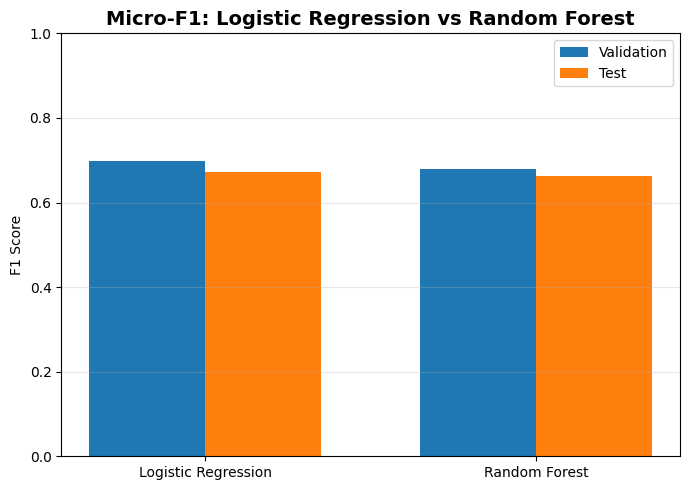

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rows = [
    ["Logistic Regression", "Validation", val_stats["micro_f1"]],
    ["Logistic Regression", "Test",       test_stats["micro_f1"]],
    ["Random Forest",       "Validation", val_stats_rf["micro_f1"]],
    ["Random Forest",       "Test",       test_stats_rf["micro_f1"]],
]
df = pd.DataFrame(rows, columns=["Model", "Set", "F1"])
print(df)

sub = df.pivot(index="Model", columns="Set", values="F1").reindex(["Logistic Regression", "Random Forest"])
x = np.arange(len(sub.index))
w = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - w/2, sub["Validation"].values, width=w, label="Validation")
plt.bar(x + w/2, sub["Test"].values,       width=w, label="Test")

plt.title("Micro-F1: Logistic Regression vs Random Forest", fontsize=14, fontweight="bold")
plt.xticks(x, sub.index, rotation=0)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
